In [1]:
import os
import torch
import accelerate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


#from huggingface_hub import create_repo, upload_folder


from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from accelerate import Accelerator
from diffusers import UNet2DModel
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from diffusers.utils import make_image_grid
from diffusers.optimization import get_cosine_schedule_with_warmup






In [2]:
is_cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda:0


In [3]:
torch.__version__
print(accelerate.__version__)


1.2.1


In [4]:
# import torch.multiprocessing as mp
# mp.set_start_method("spawn")



In [5]:
train_data = pd.read_csv("/home/could714/diff_plant/dataset/trainset")
valid_data = pd.read_csv("/home/could714/diff_plant/dataset/validset")
test_data = pd.read_csv("/home/could714/diff_plant/dataset/testset")


In [6]:
valid_data[valid_data['labels'] == 0]

,image,labels
0,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
1,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
2,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
3,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
4,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
...,...,...
56,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
57,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
58,/home/could714/diff_plant/dataset/BeanLeaf/202...,0
59,/home/could714/diff_plant/dataset/BeanLeaf/202...,0


In [140]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-plant-256"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 42


config = TrainingConfig()

In [141]:
from torchvision import transforms

# preprocess = transforms.Compose(
#     [
#         transforms.Resize((config.image_size, config.image_size)),
#         transforms.Lambda(lambda x: ((x - x.min()) * 2 / (x.max() - x.min())) - 1),
#         #transforms.Normalize([0.5], [0.5]),
#     ]
# )

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ConvertImageDtype(torch.float32),
    ]
)


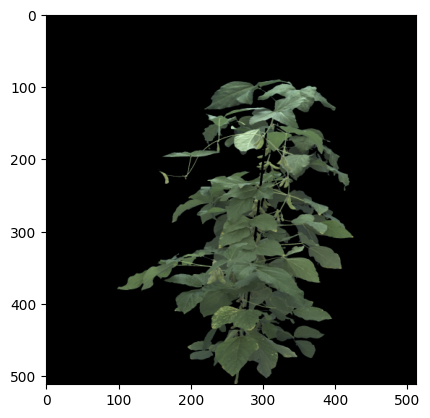

In [153]:
sample = read_image(train_data.loc[2000,'image'])
plt.imshow(sample.permute(1,2,0))

image shape = torch.Size([3, 256, 256])
max value = 0.9137254953384399, min value = 0.0 


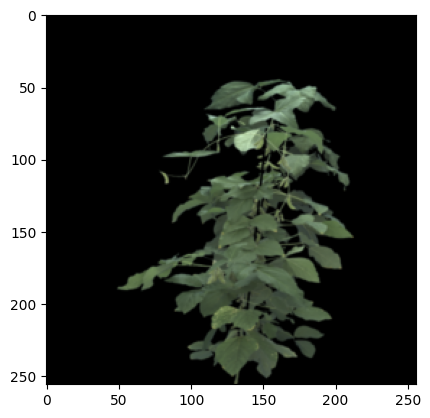

In [159]:
processed_sample = preprocess(sample)
print(f'image shape = {processed_sample.shape}')
print(f'max value = {processed_sample.max()}, min value = {processed_sample.min()} ')
plt.imshow(processed_sample.permute(1,2,0))

In [129]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transforms):
        
        self.img = annotations_file['image']
        self.transform = transforms
        self.targets = np.array(annotations_file['labels'])
        

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img_path = self.img[idx]
        image = read_image(img_path)
        label = self.targets[idx]
    
        image = self.transform(image)
        
        return image, label

In [144]:
train_dataset = CustomImageDataset(train_data, preprocess)
valid_dataset = CustomImageDataset(valid_data[valid_data['labels'] == 0], preprocess)
test_dataset = CustomImageDataset(test_data[test_data['labels'] == 0], preprocess)

In [145]:
train_dataloader = DataLoader(train_dataset, batch_size = config.train_batch_size, shuffle = True, pin_memory = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 16, shuffle = False, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)


In [14]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64,64, 128, 128, 256, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
    class_embed_type = 'timestep',
)

In [160]:
processed_sample.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.544759..3.2973256].


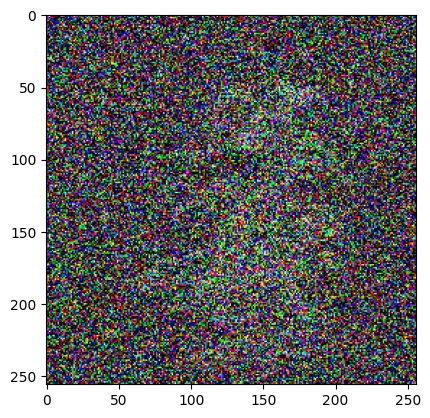

In [167]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(processed_sample.shape)
timesteps = torch.LongTensor([300])
noisy_image = noise_scheduler.add_noise(processed_sample, noise, timesteps)

plt.imshow(noisy_image.permute(1,2,0))

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1)) * 255.0).type(torch.uint8).numpy()[7])

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3524678..1.5508391].


torch.Size([16, 3, 256, 256])
torch.Size([16])


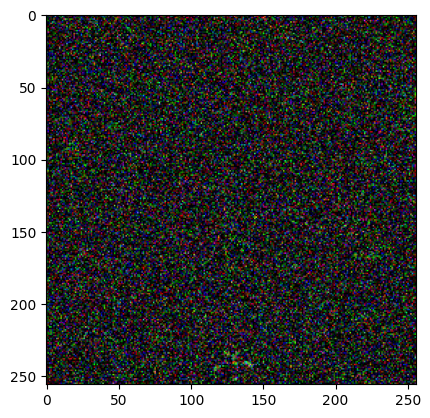

In [179]:
test_sample = next(iter(valid_dataloader))[0]
test_labels = next(iter(valid_dataloader))[1]

test_timesteps = torch.LongTensor([100])

test_noise = torch.randn(test_sample.shape)
test_noisy_images = noise_scheduler.add_noise(test_sample, test_noise, test_timesteps)

print(test_noisy_images.shape)
print(test_labels.shape)

plt.imshow((test_noisy_images.permute(0,2,3,1)).numpy()[11])
#Image.fromarray(((test_noisy_images.permute(0, 2, 3, 1)) * 255.0).type(torch.uint8).numpy()[1])

In [18]:
# noise_pred = model(noisy_image, timesteps).sample
# loss = F.mse_loss(noise_pred, noise)

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [22]:
def numpy_to_pil(images):
    r"""
    Convert a NumPy image or a batch of images to a list of PIL images.

    Args:
        images (`np.ndarray`):
            The input NumPy array of images, which can be a single image or a batch.

    Returns:
        `List[PIL.Image.Image]`:
            A list of PIL images converted from the input NumPy array.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image[:, :, :3]) for image in images]

    return pil_images



def Image_Sampling(model, sample, timesteps, class_label, scheduler, generator=torch.Generator(device='cpu').manual_seed(config.seed), output_type = "pil", ):
    scheduler.set_timesteps(num_inference_steps = timesteps)

    for t in tqdm(scheduler.timesteps, desc = 'Sampling Process'):
        
        model_output = model(sample, t, class_label).sample
        sample = scheduler.step(model_output, t, sample, generator=generator).prev_sample

    sample = sample.clamp(0,1)
    sample = sample.cpu().permute(0,2,3,1).numpy()

    if output_type == 'pil':
        sample = numpy_to_pil(sample)

    return (sample,) ## List[PIL.Image.Image]

    

In [23]:
## Validation Set 도 추가 해봐야함

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    patience = 0
    before_loss = 999999.0
    
    #Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        total_loss = 0

        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            clean_labels = batch[1]
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0] # batch size

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, class_labels = clean_labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                total_loss += loss
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            with torch.no_grad():
                if (total_loss / len(train_dataloader.dataset)) < before_loss:
                    print(f"Modeled save at {epoch}, Loss = {(total_loss / len(train_dataloader.dataset)):.5f}")
                    model.save_pretrained(config.output_dir + '/diff_256.pt')
                    patience = 0
                    images = Image_Sampling(model = accelerator.unwrap_model(model), sample = test_noisy_images.to(device), timesteps= 100, class_label = torch.tensor([10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]).to(device), scheduler=noise_scheduler)
                    image_grid = make_image_grid(images[0], rows=4, cols=4)

                    # Save the images
                    test_dir = os.path.join(config.output_dir, "samples")
                    os.makedirs(test_dir, exist_ok=True)
                    image_grid.save(f"{test_dir}/{epoch:04d}.png")
                    
                else:
                    patience += 1
                    if patience >= int(config.num_epochs * 0.1):
                        print("Early Stopping")
                        break
                        
                
                
                # if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                #     images = Image_Sampling(model = accelerator.unwrap_model(model), sample = test_noisy_images.to(device), timesteps= 100, class_label = torch.tensor([10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]).to(device), scheduler=noise_scheduler)
                #     image_grid = make_image_grid(images[0], rows=4, cols=4)

                #     # Save the images
                #     test_dir = os.path.join(config.output_dir, "samples")
                #     os.makedirs(test_dir, exist_ok=True)
                #     image_grid.save(f"{test_dir}/{epoch:04d}.png")

                # if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                #     model.save_pretrained(config.output_dir + '/diff_256.pt')




In [ ]:
from accelerate import notebook_launcher


args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 0, Loss = 0.04440


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 1, Loss = 0.00496


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 2, Loss = 0.00196


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 3, Loss = 0.00130


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 4, Loss = 0.00085


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 5, Loss = 0.00068


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 6, Loss = 0.00052


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 7, Loss = 0.00052


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 8, Loss = 0.00044


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 9, Loss = 0.00039


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 10, Loss = 0.00036


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 11, Loss = 0.00034


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 12, Loss = 0.00031


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 13, Loss = 0.00030


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 14, Loss = 0.00027


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 15, Loss = 0.00029


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 16, Loss = 0.00024


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 17, Loss = 0.00023


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 18, Loss = 0.00026


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 19, Loss = 0.00024


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 20, Loss = 0.00023


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 21, Loss = 0.00019


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 22, Loss = 0.00023


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 23, Loss = 0.00023


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 24, Loss = 0.00021


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 25, Loss = 0.00020


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 26, Loss = 0.00018


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 27, Loss = 0.00020


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 28, Loss = 0.00019


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 29, Loss = 0.00020


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 30, Loss = 0.00020


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 31, Loss = 0.00020


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 32, Loss = 0.00019


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 33, Loss = 0.00019


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 34, Loss = 0.00019


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 35, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 36, Loss = 0.00016


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 37, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 38, Loss = 0.00018


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 39, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 40, Loss = 0.00016


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 41, Loss = 0.00018


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 42, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 43, Loss = 0.00018


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 44, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 45, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 46, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Modeled save at 47, Loss = 0.00017


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

## 확인 사항 
* 이미지 시각화 하는 식이 맞는지 확인 필요함 255 * clamp(0,1) 해당 부분확인 (-1, 1)이 아닌 0~1 사이로 정규화
* noise_schdule 종류에 따른 성능 변화 확인 , DDIM or SDE Scheduler
* 학습 횟수의 부족에 의한 문제일 가능성
* 학습은 1천으로 하고 샘플링 할때엔 Scheduler를 100으로 세팅 했는데 이게 문제가 될 것인지, sampling step 차이에 따른 횟수나 길이에 대해 생각 >> 문제 될듯, 확인해보니 sampling을 100 하면 100번째에서 시작이 아니라 990부터 0까지 100번을 수행함. 나는 100의 noise가 낀 것을 주었으니 100 부터 1로 차근차근 수행되어야함 >> 이거 변경 필요
* noise 100 sampling 100이 아닌 noise 100 sampling 200과 같은 방식으로 수행
* 

In [122]:
trained_model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64,64, 128, 128, 256, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
    class_embed_type = 'timestep',
).from_pretrained(config.output_dir + '/diff_256.pt',)

In [124]:
trained_model= UNet2DModel().from_pretrained(config.output_dir + '/diff_256.pt')

In [126]:
trained_model

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, 

In [115]:
def Image_Sampling_Visualization(model, sample, timesteps, class_label, scheduler, generator=torch.Generator(device='cpu').manual_seed(config.seed), output_type = "pil", ):
    scheduler.set_timesteps(num_inference_steps = timesteps)
    
    for t in tqdm(scheduler.timesteps, desc = 'Sampling Process'):
        with torch.no_grad():
            model.eval()
            model_output = model(sample = sample, timestep = t, class_labels = class_label).sample
            sample = scheduler.step(model_output = model_output, timestep =t, sample = sample, generator=generator).prev_sample

    sample = sample.clamp(0,1)
    sample = sample.cpu().permute(0,2,3,1).numpy()

    plt.imshow(sample[0])
    plt.show()

    
    return sample
     ## List[PIL.Image.Image]

In [92]:
device = torch.device('cuda:3' if is_cuda else 'cpu')


Sampling Process:   0%|          | 0/100 [00:00<?, ?it/s]

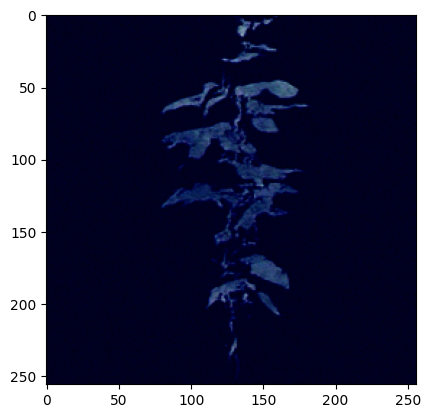

In [93]:
Image_Sampling_Visualization(model = trained_model.to(device), sample = test_noisy_images[:5].to(device), timesteps= 100, class_label = torch.tensor([10,10,10,10,10]).to(device), scheduler=noise_scheduler)

In [180]:
valid_0_image = test_noisy_images[0]



tensor([[[[ 1.5297e-01, -4.2682e-02,  9.5971e-02,  ...,  4.9739e-01,
            3.9285e-01,  2.8373e-01],
          [-1.4094e-01, -3.0417e-01, -3.5537e-01,  ...,  2.7118e-01,
           -2.1405e-01, -1.9205e-01],
          [-3.0997e-01,  2.0017e-01,  2.7786e-01,  ..., -1.4129e-01,
           -1.1153e-01, -3.0958e-01],
          ...,
          [-1.1476e-01,  2.7283e-01,  1.7620e-01,  ..., -8.2952e-02,
           -7.6276e-01, -1.4171e-01],
          [ 1.1658e-01, -2.9187e-01, -2.2530e-01,  ..., -1.5249e-01,
           -9.4305e-02, -1.7574e-01],
          [ 2.9805e-01, -1.4842e-01, -6.8269e-02,  ...,  3.4504e-01,
            1.2853e-01,  5.5012e-01]],

         [[-3.0745e-02, -2.2616e-02,  1.5825e-01,  ..., -3.0348e-01,
           -5.9636e-01, -2.3138e-01],
          [ 4.1242e-01, -3.9689e-01,  4.1427e-01,  ...,  6.7636e-02,
            2.0525e-01,  6.3867e-01],
          [ 2.4369e-01,  2.5661e-01, -1.1704e-01,  ..., -7.7028e-02,
           -2.9765e-01, -1.3493e-01],
          ...,
     

tensor([[[ 7.6487e-01, -2.1341e-01,  4.7986e-01,  ...,  2.4869e+00,
           1.9642e+00,  1.4186e+00],
         [-7.0472e-01, -1.5209e+00, -1.7768e+00,  ...,  1.3559e+00,
          -1.0702e+00, -9.6026e-01],
         [-1.5499e+00,  1.0009e+00,  1.3893e+00,  ..., -7.0646e-01,
          -5.5766e-01, -1.5479e+00],
         ...,
         [-5.7382e-01,  1.3642e+00,  8.8101e-01,  ..., -4.1476e-01,
          -3.8138e+00, -7.0857e-01],
         [ 5.8292e-01, -1.4593e+00, -1.1265e+00,  ..., -7.6247e-01,
          -4.7153e-01, -8.7868e-01],
         [ 1.4903e+00, -7.4208e-01, -3.4134e-01,  ...,  1.7252e+00,
           6.4264e-01,  2.7506e+00]],

        [[-1.5373e-01, -1.1308e-01,  7.9125e-01,  ..., -1.5174e+00,
          -2.9818e+00, -1.1569e+00],
         [ 2.0621e+00, -1.9844e+00,  2.0713e+00,  ...,  3.3818e-01,
           1.0262e+00,  3.1934e+00],
         [ 1.2185e+00,  1.2831e+00, -5.8521e-01,  ..., -3.8514e-01,
          -1.4883e+00, -6.7467e-01],
         ...,
         [ 1.7652e+00,  6

In [ ]:
# model_output = model(sample.to(device), 1, class_labels = torch.tensor([2]).to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4921077..1.4097269].


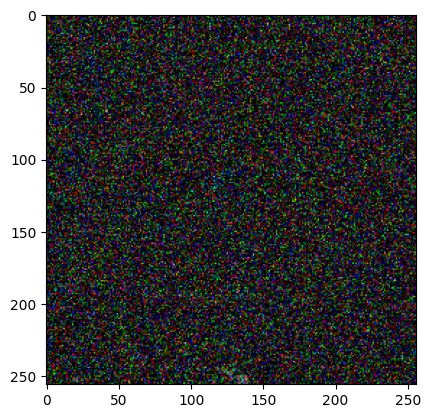

In [74]:
plt.imshow(test_noisy_images.permute(0,2,3,1)[4])

In [84]:
test_noisy_images[:5].shape

torch.Size([5, 3, 256, 256])